#EDA

**Cell-overzicht (kort)**

1. Titel: korte titel van dit notebook.

2. Imports: laadt `numpy`, `pandas`, `matplotlib` en `seaborn` en zet visuele stijl; vereist voor alle plots en data-manipulatie.

3. Data-locatie: definieert `DATA_DIR` en zoekt alle CSV-bestanden in `Data/` (laat zien welke bestanden worden gebruikt).

4. Functies: `load_csv_hits()` en `print_basic_stats()` — verwerkt CSV-formaten naar per-hit arrays (vorm: n_hits × n_samples) en print samenvattingen (aantal hits, samples per hit, amplitude-statistieken, per-hit RMS).

5. Laden & samenvatting: laadt alle CSV's met `load_csv_hits()`, bewaart ze in `data` en bouwt een snel overzichtstabel (`file`, `n_hits`, `n_samples`).

6. Waveforms: toont overlay van de eerste n hits per bestand plus de gemiddelde golfvorm met ±1 std (handig om variatie en alignement te zien).

7. Amplitude-distributies: per-bestand KDE's en gecombineerde histogrammen — geeft inzicht in amplitudeverdeling en mogelijke clipping/noise.

8. FFT: gemiddelde magnitude-spectrum over hits (log-scale) — helpt bij het identificeren van dominante frequentiebanden karakteristiek voor materiaal of impact.

9. RMS-analyse: per-hit RMS-distributie en rolling-RMS voorbeeld voor een hit — handig om energieverschillen tussen slagen te visualiseren.


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style="whitegrid")
%matplotlib inline

In [97]:
# --- Clone specifieke branch 'Data' naar een lokale folder 'Data' ---
!git clone --branch Data https://github.com/NielsVanthournout1/AI-Edge-Computing-Opdracht-2-Magic-Hammer.git Data

# --- Controleer de inhoud van de Data folder ---
import os


print("Bestanden in folder 'Data':")
print(os.listdir("Data"))

DATA_DIR = Path("Data")
files = list(DATA_DIR.glob('*.csv'))
files

fatal: destination path 'Data' already exists and is not an empty directory.
Bestanden in folder 'Data':
['mes.csv', 'Book.csv', 'metalen_pot.csv', '.git', 'wood.csv', 'blik.csv', 'steen.csv', 'hammer.csv']


[PosixPath('Data/mes.csv'),
 PosixPath('Data/Book.csv'),
 PosixPath('Data/metalen_pot.csv'),
 PosixPath('Data/wood.csv'),
 PosixPath('Data/blik.csv'),
 PosixPath('Data/steen.csv'),
 PosixPath('Data/hammer.csv')]

In [98]:
def load_csv_hits(path, expected_len=4800):
    """Load CSV and return hits as a 2D numpy array: (n_hits, n_samples).
    Handles rows-as-hits, single-row CSVs, or single-column continuous samples.
    """
    df = pd.read_csv(path, header=0)
    arr = df.values
    # If single column of many rows, try to split into hits
    if arr.shape[1] == 1:
        flat = arr.ravel()
        if flat.size % expected_len == 0:
            hits = flat.reshape(-1, expected_len)
        else:
            # fallback: treat whole column as one long hit
            hits = flat.reshape(1, -1)
    else:
        # If each row looks like a hit (many columns)
        # If number of columns equals expected_len, good
        if arr.shape[1] == expected_len:
            hits = arr
        elif arr.shape[0] == expected_len and arr.shape[1] != expected_len:
            # maybe transposed
            hits = arr.T
        else:
            # fallback: flatten and try to chunk
            flat = arr.ravel()
            if flat.size % expected_len == 0:
                hits = flat.reshape(-1, expected_len)
            else:
                hits = arr  # give up and return raw
    hits = hits.astype(float)
    return hits


def print_basic_stats(name, hits):
    """Print useful per-file statistics. `hits` is 2D: (n_hits, n_samples) or 1D array."""
    if hits.ndim == 1:
        arr = hits
        print(f'--- {name} (flattened) ---')
        print('samples:', arr.size)
        s = pd.Series(arr)
        print(s.describe())
    else:
        n_hits, n_samples = hits.shape
        print(f'--- {name} ---')
        print('hits:', n_hits)
        print('samples per hit:', n_samples)
        s = pd.Series(hits.ravel())
        print('overall amplitude stats:')
        print(s.describe())
        per_hit_rms = np.sqrt(np.mean(hits**2, axis=1))
        print('per-hit RMS stats:')
        print(pd.Series(per_hit_rms).describe())
    print('\n')

In [99]:
# Laad de CSVs en print samenvattingen
expected_len = 4800

data = {}
for f in files:
    hits = load_csv_hits(f, expected_len=expected_len)
    data[f.name] = hits
    print_basic_stats(f.name, hits)

# Show a quick summary table
summary = []
for name,hits in data.items():
    if hits.ndim == 1:
        n_hits = 1
        n_samples = hits.size
    else:
        n_hits, n_samples = hits.shape
    summary.append({'file': name, 'n_hits': n_hits, 'n_samples': n_samples})
pd.DataFrame(summary)


--- mes.csv ---
hits: 106
samples per hit: 4800
overall amplitude stats:
count    508800.000000
mean       1706.998801
std        1437.847375
min       -6983.000000
25%         720.000000
50%        1361.000000
75%        2398.000000
max       16929.000000
dtype: float64
per-hit RMS stats:
count     106.000000
mean     2068.233051
std       842.828256
min       758.738097
25%      1404.384950
50%      1974.894165
75%      2669.647191
max      5547.578500
dtype: float64


--- Book.csv ---
hits: 21
samples per hit: 4800
overall amplitude stats:
count    100800.000000
mean       -870.982212
std        1836.964440
min      -20442.000000
25%       -1033.000000
50%        -329.000000
75%         -71.000000
max       20610.000000
dtype: float64
per-hit RMS stats:
count      21.000000
mean     1961.247611
std       548.496886
min      1148.310889
25%      1501.858563
50%      1917.754708
75%      2318.135370
max      3003.177821
dtype: float64


--- metalen_pot.csv ---
hits: 21
samples per hit

,file,n_hits,n_samples
0,mes.csv,106,4800
1,Book.csv,21,4800
2,metalen_pot.csv,21,4800
3,wood.csv,100,4800
4,blik.csv,96,4800
5,steen.csv,112,4800
6,hammer.csv,100,4800


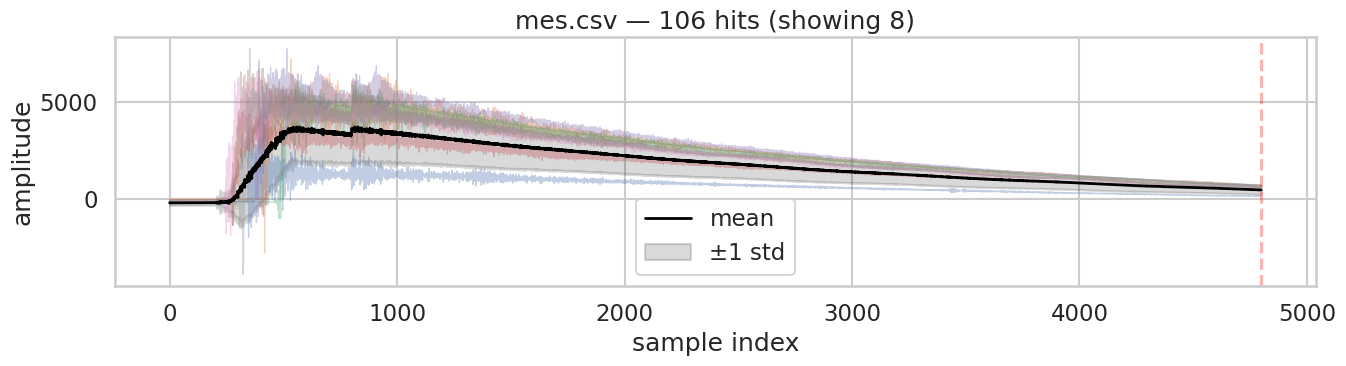

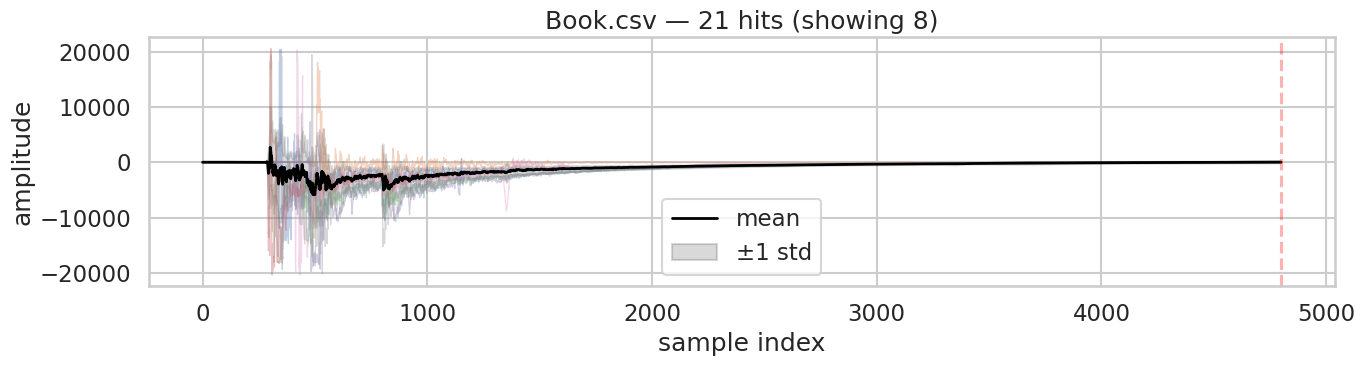

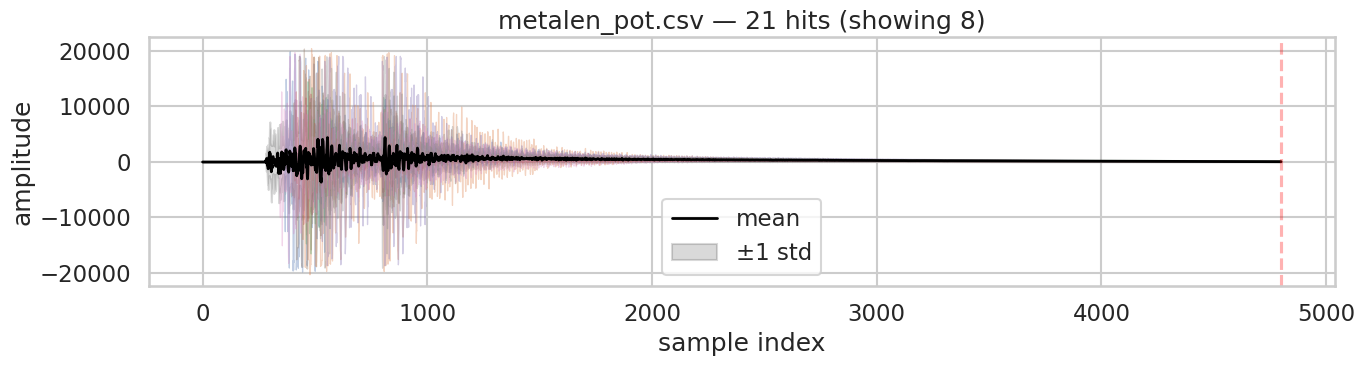

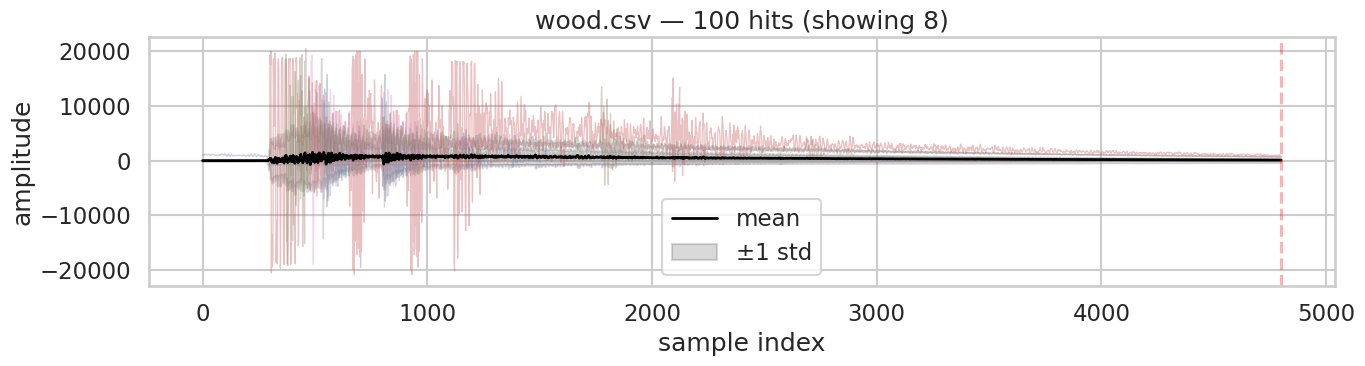

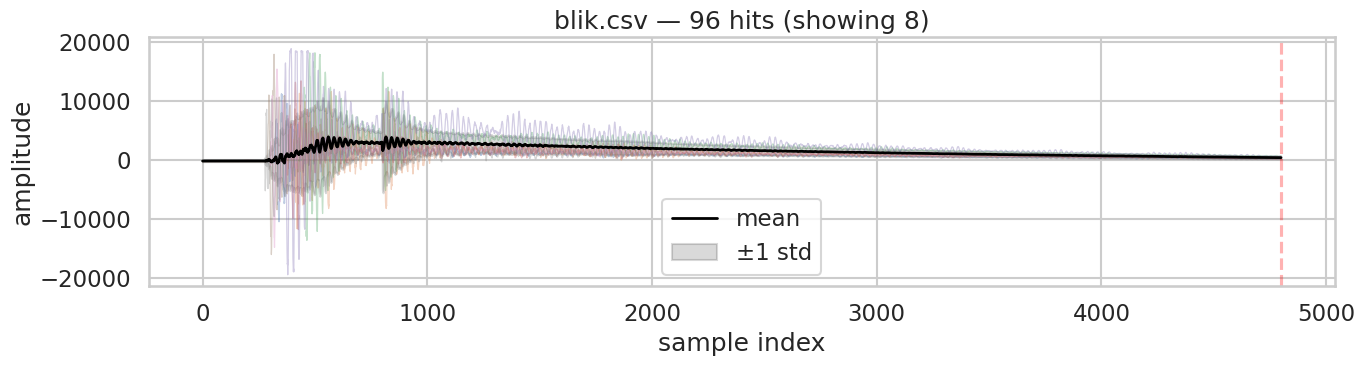

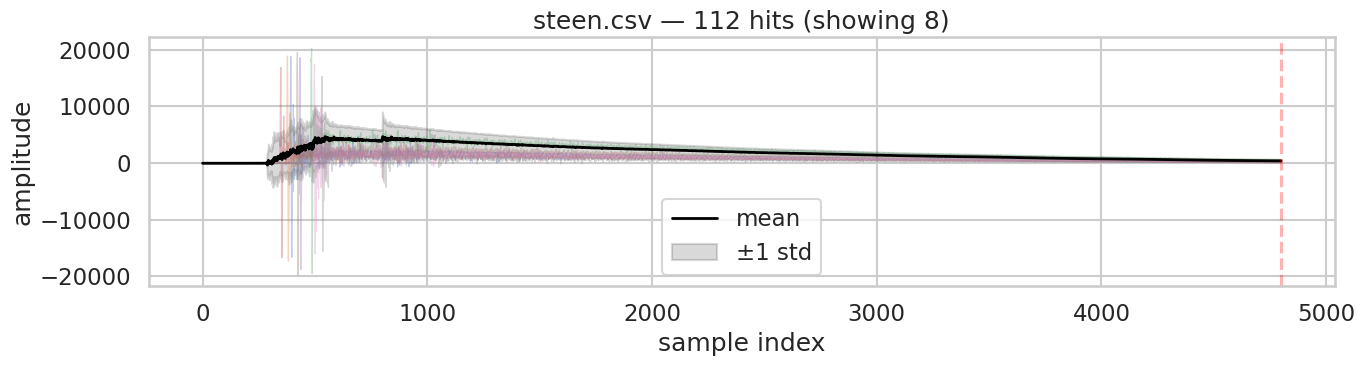

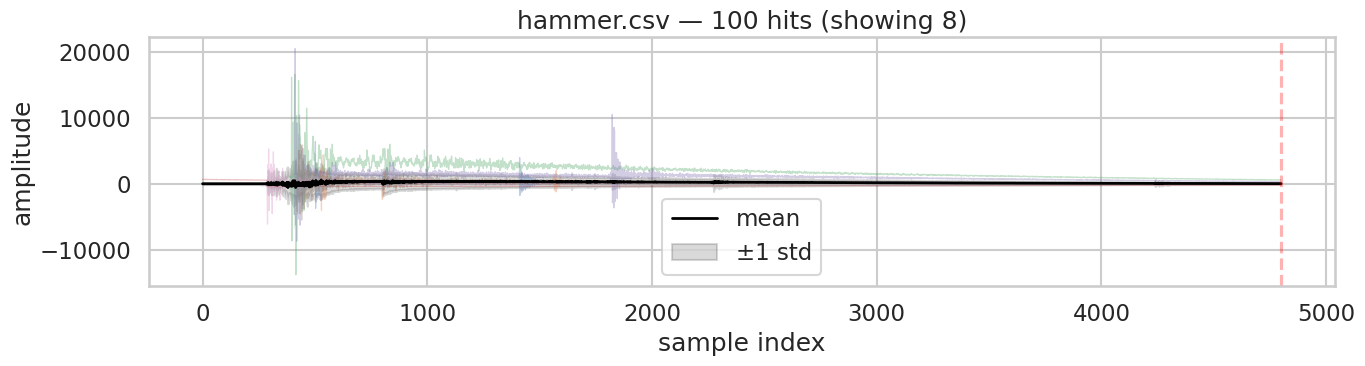

In [100]:
# Waveform plots (overlay first few hits + mean ± std)
sns.set_context('talk')
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1, -1)
    else:
        hits2 = hits
    n_hits, n_samples = hits2.shape
    display_hits = min(8, n_hits)
    plt.figure(figsize=(14,4))
    x = np.arange(n_samples)
    # plot a few individual hits
    for i in range(display_hits):
        plt.plot(x, hits2[i], alpha=0.35, linewidth=0.9)
    # mean and std shading
    mean_wf = hits2.mean(axis=0)
    std_wf = hits2.std(axis=0)
    plt.plot(x, mean_wf, color='black', linewidth=2.0, label='mean')
    plt.fill_between(x, mean_wf-std_wf, mean_wf+std_wf, color='black', alpha=0.15, label='±1 std')
    plt.title(f'{name} — {n_hits} hits (showing {display_hits})')
    plt.xlabel('sample index')
    plt.ylabel('amplitude')
    plt.axvline(expected_len, color='red', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()

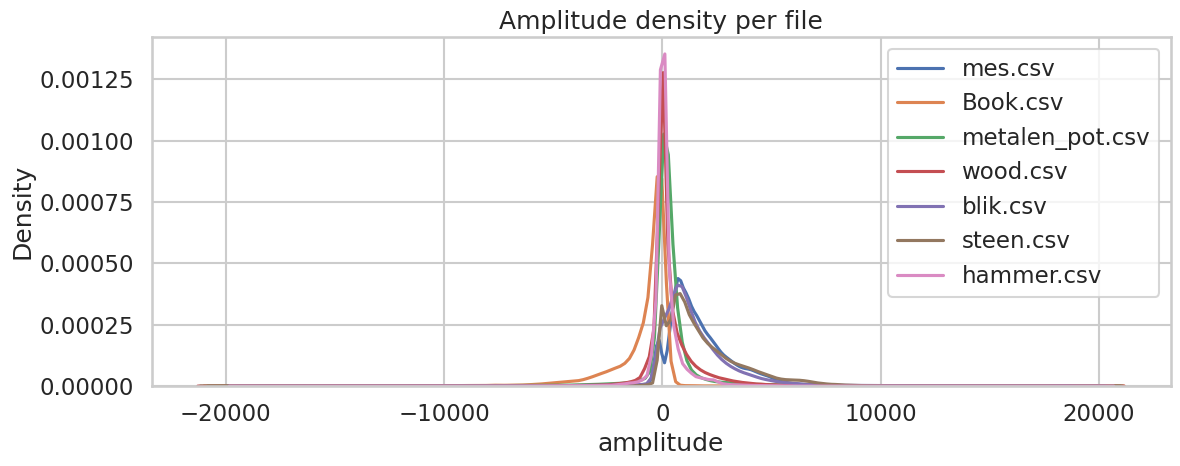

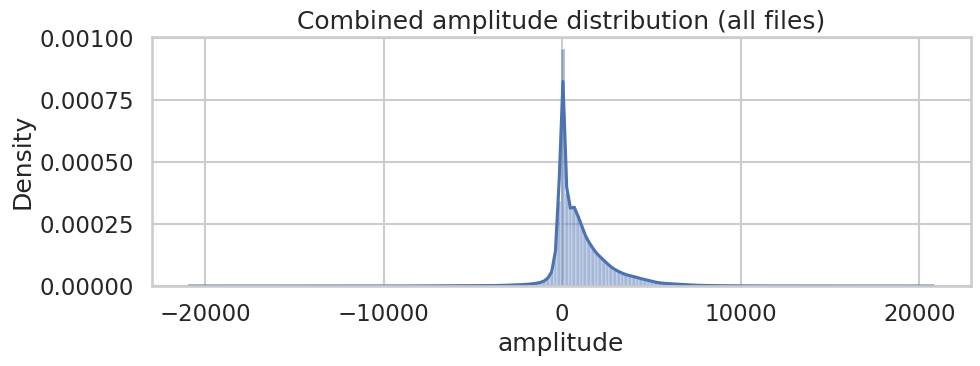

In [101]:
# Amplitude distribution: combined & per-file KDE/hist
plt.figure(figsize=(12,5))
for i,(name,hits) in enumerate(data.items()):
    arr = hits.ravel() if hits.ndim>1 else hits
    sns.kdeplot(arr, label=name, bw_adjust=1.0, clip=(-np.inf, np.inf))
plt.title('Amplitude density per file')
plt.xlabel('amplitude')
plt.legend()
plt.tight_layout()

# Combined histogram with rug
plt.figure(figsize=(10,4))
all_vals = np.hstack([h.ravel() if h.ndim>1 else h for h in data.values()])
sns.histplot(all_vals, bins=200, kde=True, stat='density', color='C0')
plt.title('Combined amplitude distribution (all files)')
plt.xlabel('amplitude')
plt.tight_layout()

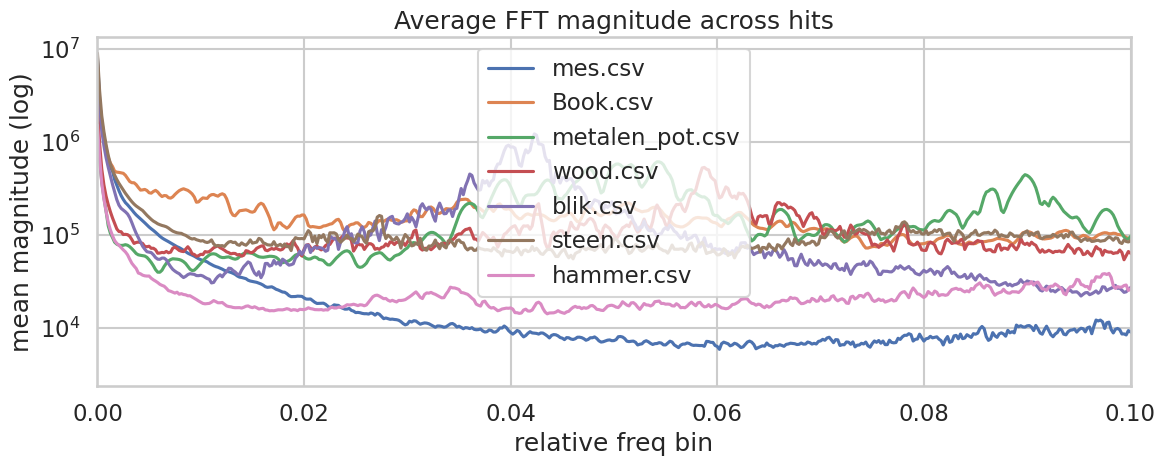

In [102]:
# FFT: average magnitude spectrum across hits (log scale)
plt.figure(figsize=(12,5))
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1,-1)
    else:
        hits2 = hits
    n_hits, n_samples = hits2.shape
    specs = np.abs(np.fft.rfft(hits2, axis=1))
    mean_spec = specs.mean(axis=0)
    freqs = np.fft.rfftfreq(n_samples, d=1.0)
    plt.plot(freqs, mean_spec, label=name)
plt.yscale('log')
plt.xlim(0, freqs.max()*0.2)
plt.xlabel('relative freq bin')
plt.ylabel('mean magnitude (log)')
plt.title('Average FFT magnitude across hits')
plt.legend()
plt.tight_layout()


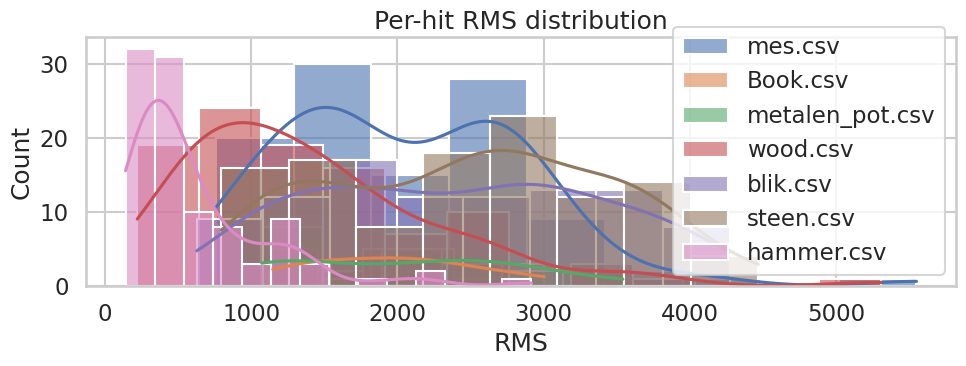

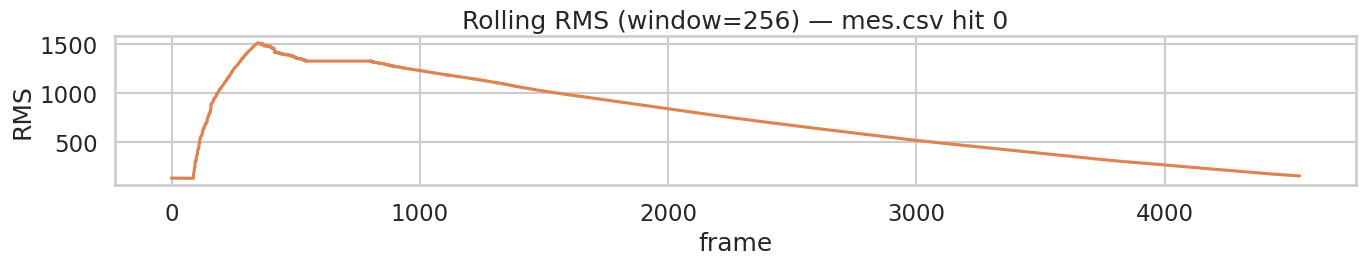

In [103]:
# RMS: per-hit RMS distribution + rolling RMS for example hit
plt.figure(figsize=(10,4))
rms_per_hit = {}
for name,hits in data.items():
    if hits.ndim == 1:
        hits2 = hits.reshape(1,-1)
    else:
        hits2 = hits
    per_hit = np.sqrt(np.mean(hits2**2, axis=1))
    rms_per_hit[name] = per_hit
    sns.histplot(per_hit, kde=True, label=name, alpha=0.6)
plt.title('Per-hit RMS distribution')
plt.xlabel('RMS')
plt.legend()
plt.tight_layout()

# Rolling RMS for first file, first hit
first_name = list(data.keys())[0]
hits = data[first_name]
if hits.ndim == 1:
    sig = hits
else:
    sig = hits[0]

# rolling RMS using numpy (no scipy dependency)
def rolling_rms_vec(sig, window=256):
    if sig.size < window:
        window = max(1, sig.size//10)
    s = np.sqrt(np.convolve(sig**2, np.ones(window)/window, mode='valid'))
    return s

r = rolling_rms_vec(sig, window=256)
plt.figure(figsize=(14,3))
plt.plot(r, color='C1')
plt.title(f'Rolling RMS (window=256) — {first_name} hit 0')
plt.xlabel('frame')
plt.ylabel('RMS')
plt.tight_layout()

#PREPROCESSING

In [104]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
import joblib

In [105]:
# Paths
DATA_DIR = Path("/content/Data")
PROCESSED_DIR = Path("/content/processed")
NORMALIZED_DIR = Path("/content/normalized")

# Maak folders aan
PROCESSED_DIR.mkdir(exist_ok=True)
NORMALIZED_DIR.mkdir(exist_ok=True)

# MFE Parameters
SR = 16000  # Sample rate
N_MELS = 13  # Number of mel bands
N_FFT = 256  # FFT window size
HOP_LENGTH = 512  # Hop length for STFT
TARGET_FRAMES = 10

print(f"Data directory: {DATA_DIR}")
print(f"Processed directory: {PROCESSED_DIR}")
print(f"Normalized directory: {NORMALIZED_DIR}")
print(f"MFE Parameters: n_mels={N_MELS}, n_fft={N_FFT}, hop_length={HOP_LENGTH}")

Data directory: /content/Data
Processed directory: /content/processed
Normalized directory: /content/normalized
MFE Parameters: n_mels=13, n_fft=256, hop_length=512


In [106]:
import math
import cmath

def extract_mfe_features(audio_data, n_mels=13, n_fft=256, hop_length=512):
    """
    Extract simplified Mel-Frequency Energy (MFE) features, Arduino-friendly.

    Parameters:
    - audio_data: list of floats (audio samples)
    - n_mels: number of mel bands
    - n_fft: FFT window size
    - hop_length: hop length for frame processing

    Returns:
    - mfe_features: list of lists containing energy per mel band per frame
    """
    def fft(x):
        """Simple FFT implementation (radix-2, length must be power of 2)."""
        N = len(x)
        if N <= 1: return x
        even = fft(x[0::2])
        odd = fft(x[1::2])
        T = [cmath.exp(-2j * math.pi * k / N) * odd[k] for k in range(N // 2)]
        return [even[k] + T[k] for k in range(N // 2)] + \
               [even[k] - T[k] for k in range(N // 2)]

    mfe_features = []
    for start in range(0, len(audio_data) - n_fft + 1, hop_length):
        frame = audio_data[start:start+n_fft]
        # Apply Hamming window
        windowed = [frame[i] * (0.54 - 0.46 * math.cos(2 * math.pi * i / (n_fft - 1))) for i in range(n_fft)]
        # Compute FFT
        spectrum = fft(windowed)
        mag = [abs(s) ** 2 for s in spectrum[:n_fft // 2]]  # power spectrum
        # Map FFT bins to mel bands
        bins_per_band = (n_fft // 2) // n_mels
        mel_energy = []
        for b in range(n_mels):
            start_bin = b * bins_per_band
            end_bin = start_bin + bins_per_band
            energy = sum(mag[start_bin:end_bin]) / bins_per_band
            mel_energy.append(energy)
        mfe_features.append(mel_energy)

    return mfe_features


In [107]:
import math

def preprocess_signal(signal, sr=16000):
    """
    Arduino-friendly preprocessing of audio signal:
    - DC removal
    - Simple high-pass filter
    - Peak alignment
    - Peak normalization

    Parameters:
    - signal: list of floats (audio samples)
    - sr: sample rate

    Returns:
    - processed_signal: list of floats
    """
    # DC removal
    mean_val = sum(signal) / len(signal)
    signal = [s - mean_val for s in signal]

    # Simple first-order high-pass filter (approximate 20 Hz cutoff)
    alpha = 0.95  # adjust between 0 and 1; lower -> more aggressive high-pass
    prev_input = signal[0]
    prev_output = signal[0]
    filtered = [prev_output]
    for s in signal[1:]:
        out = alpha * (prev_output + s - prev_input)
        filtered.append(out)
        prev_input = s
        prev_output = out
    signal = filtered

    # Find peak and align
    peak_idx = max(range(len(signal)), key=lambda i: abs(signal[i]))
    if peak_idx > 100:
        signal = signal[peak_idx-100:]

    # Peak normalization
    max_val = max(abs(s) for s in signal)
    if max_val > 0:
        signal = [s / max_val for s in signal]

    return signal


In [108]:
print(f"\n{'='*60}")
print("STAP 1: VERWERKEN VAN RAW DATA NAAR MFE FEATURES")
print(f"{'='*60}")

# Vind alle CSV bestanden in de Data folder (DYNAMISCH)
csv_files = list(DATA_DIR.glob("*.csv"))
print(f"\nGevonden CSV bestanden: {[f.name for f in csv_files]}")

if len(csv_files) == 0:
    print("⚠️  WAARSCHUWING: Geen CSV bestanden gevonden in Data folder!")
else:
    # Verwerk elk CSV bestand
    for csv_file in csv_files:
        print(f"\n{'='*60}")
        print(f"Verwerken: {csv_file.name}")
        print(f"{'='*60}")

        # Lees CSV data
        df = pd.read_csv(csv_file)
        print(f"  Originele shape: {df.shape}")
        print(f"  Aantal samples per rij: {df.shape[1]}")
        print(f"  Aantal hits (rijen): {df.shape[0]}")

        # Bereken MFE features voor elke hit
        all_mfe_features = []

        for idx, row in df.iterrows():
            # Converteer rij naar 1D numpy array (audio samples)
            audio_data = row.values.astype(np.float32)

            # Pas MFE preprocessing toe
            mfe_features = extract_mfe_features(audio_data, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)

            # Force fixed number of frames so flatten size is always TARGET_FRAMES * N_MELS (10 * 13 = 130)
            if len(mfe_features) == 0:
                # edge case: no frames -> create all-zero frames
                mfe_features = [[0.0] * N_MELS for _ in range(TARGET_FRAMES)]
            elif len(mfe_features) < TARGET_FRAMES:
                # pad by repeating last frame (or use zeros if you prefer)
                last = mfe_features[-1]
                mfe_features = mfe_features + [last[:] for _ in range(TARGET_FRAMES - len(mfe_features))]
            else:
                # truncate
                mfe_features = mfe_features[:TARGET_FRAMES]


            # Flatten lijst van lijsten naar 1D
            mfe_flat = [item for sublist in mfe_features for item in sublist]
            all_mfe_features.append(mfe_flat)

            if idx == 0:  # Print info voor eerste hit
                n_frames = len(mfe_features)
                n_mels = len(mfe_features[0]) if n_frames > 0 else 0
                print(f"  MFE features shape per hit: ({n_frames}, {n_mels})")
                print(f"  MFE flattened size: {len(mfe_flat)}")

        # Converteer naar DataFrame
        mfe_df = pd.DataFrame(all_mfe_features)

        # Sla op in processed folder (voeg '_processed' toe aan bestandsnaam)
        output_file = PROCESSED_DIR / f"{csv_file.stem}_processed.csv"
        mfe_df.to_csv(output_file, index=False)
        print(f"  ✓ Opgeslagen: {output_file.name}")
        print(f"  Output shape: {mfe_df.shape}")

    print(f"\n{'='*60}")
    print(f"✓ Alle bestanden verwerkt en opgeslagen in {PROCESSED_DIR}/")
    print(f"{'='*60}")



STAP 1: VERWERKEN VAN RAW DATA NAAR MFE FEATURES

Gevonden CSV bestanden: ['mes.csv', 'Book.csv', 'metalen_pot.csv', 'wood.csv', 'blik.csv', 'steen.csv', 'hammer.csv']

Verwerken: mes.csv
  Originele shape: (106, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 106
  MFE features shape per hit: (10, 13)
  MFE flattened size: 130
  ✓ Opgeslagen: mes_processed.csv
  Output shape: (106, 130)

Verwerken: Book.csv
  Originele shape: (21, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 21
  MFE features shape per hit: (10, 13)
  MFE flattened size: 130
  ✓ Opgeslagen: Book_processed.csv
  Output shape: (21, 130)

Verwerken: metalen_pot.csv
  Originele shape: (21, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 21
  MFE features shape per hit: (10, 13)
  MFE flattened size: 130
  ✓ Opgeslagen: metalen_pot_processed.csv
  Output shape: (21, 130)

Verwerken: wood.csv
  Originele shape: (100, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 100
  MF

In [109]:
print(f"\n{'='*60}")
print("STAP 2: NORMALISATIE VAN MFE FEATURES OP BASIS VAN ALLE DATA")
print(f"{'='*60}")

# Vind alle processed bestanden (DYNAMISCH - werkt met nieuwe data)
processed_files = list(PROCESSED_DIR.glob("*.csv"))
print(f"\nGevonden processed bestanden: {[f.name for f in processed_files]}")

if len(processed_files) == 0:
    print("⚠️  WAARSCHUWING: Geen processed bestanden gevonden!")
else:
    # Stap 1: Laad ALLE processed data om statistics te berekenen
    print("\nLaden van alle data voor statistics...")
    all_data = []
    data_info = []

    for processed_file in processed_files:
        df = pd.read_csv(processed_file)
        all_data.append(df.values)
        material_name = processed_file.stem  # Bestandsnaam zonder extensie
        data_info.append((material_name, len(df)))
        print(f"  - {material_name}: {len(df)} samples, shape {df.shape}")

    # Combineer alle data
    all_data = np.vstack(all_data)
    print(f"\n📊 TOTALE DATASET STATISTICS:")
    print(f"  Shape: {all_data.shape}")
    print(f"  Aantal materialen: {len(processed_files)}")
    print(f"  Totaal aantal samples: {all_data.shape[0]}")
    print(f"  Features per sample: {all_data.shape[1]}")
    print(f"\n  Originele MFE range: [{all_data.min():.2e}, {all_data.max():.2e}]")
    print(f"  Originele MFE mean: {all_data.mean():.2e}")
    print(f"  Originele MFE std: {all_data.std():.2e}")

    # Stap 2: Fit scaler op ALLE huidige data
    print(f"\n{'='*60}")
    print("Fitting StandardScaler op alle data...")
    scaler = StandardScaler()
    scaler.fit(all_data)

    print(f"  Scaler mean (eerste 5 features): {scaler.mean_[:5]}")
    print(f"  Scaler std (eerste 5 features): {scaler.scale_[:5]}")

    # Stap 3: Transform en save elk materiaal apart
    print(f"\n{'='*60}")
    print("Transformeren en opslaan van genormaliseerde data...")

    for processed_file in processed_files:
        df = pd.read_csv(processed_file)
        material_name = processed_file.stem

        # Transform data
        normalized = scaler.transform(df.values)

        # Save
        output_file = NORMALIZED_DIR / f"{material_name}_normalized.csv"
        pd.DataFrame(normalized).to_csv(output_file, index=False)

        print(f"  ✓ {material_name}:")
        print(f"      Shape: {normalized.shape}")
        print(f"      Range: [{normalized.min():.2f}, {normalized.max():.2f}]")
        print(f"      Mean: {normalized.mean():.3f}, Std: {normalized.std():.3f}")

    # Stap 4: Save scaler voor gebruik met nieuwe data
    scaler_file = NORMALIZED_DIR / "scaler.pkl"
    joblib.dump(scaler, scaler_file)

    print(f"\n{'='*60}")
    print(f"✓ NORMALISATIE VOLTOOID!")
    print(f"{'='*60}")
    print(f"  Scaler opgeslagen: {scaler_file}")
    print(f"  Genormaliseerde data: {NORMALIZED_DIR}/")
    print(f"  Aantal materialen verwerkt: {len(processed_files)}")

    # Stap 5: Print instructies voor nieuwe data
    print(f"\n{'='*80}")
    print("📋 INSTRUCTIES VOOR NIEUWE DATA:")
    print(f"{'='*80}")
    print("Als je nieuwe CSV's toevoegt aan de Data/ folder:")
    print("")
    print("1️⃣  Draai gewoon dit hele script opnieuw!")
    print("    - Nieuwe CSV's worden automatisch gedetecteerd")
    print("    - MFE features worden automatisch berekend")
    print("    - Scaler wordt opnieuw gefit op ALLE data (oud + nieuw)")
    print("    - Alles wordt genormaliseerd met de nieuwe scaler")
    print("")
    print("2️⃣  ALTERNATIEF: Als je de scaler VAST wilt houden (niet aanbevolen):")
    print("    - Laad oude scaler: scaler = joblib.load('normalized/scaler.pkl')")
    print("    - Transform alleen nieuwe data: normalized_new = scaler.transform(new_mfe)")
    print("")
    print("⚠️  AANBEVELING: Fit de scaler opnieuw bij elke nieuwe data toevoeging")
    print("   Dit zorgt voor betere normalisatie over de hele dataset!")
    print(f"{'='*80}\n")


STAP 2: NORMALISATIE VAN MFE FEATURES OP BASIS VAN ALLE DATA

Gevonden processed bestanden: ['blik_processed.csv', 'metalen_pot_processed.csv', 'steen_processed.csv', 'hammer_processed.csv', 'Book_processed.csv', 'wood_processed.csv', 'mes_processed.csv']

Laden van alle data voor statistics...
  - blik_processed: 96 samples, shape (96, 130)
  - metalen_pot_processed: 21 samples, shape (21, 130)
  - steen_processed: 112 samples, shape (112, 130)
  - hammer_processed: 100 samples, shape (100, 130)
  - Book_processed: 21 samples, shape (21, 130)
  - wood_processed: 100 samples, shape (100, 130)
  - mes_processed: 106 samples, shape (106, 130)

📊 TOTALE DATASET STATISTICS:
  Shape: (556, 130)
  Aantal materialen: 7
  Totaal aantal samples: 556
  Features per sample: 130

  Originele MFE range: [4.52e+00, 2.51e+11]
  Originele MFE mean: 6.57e+08
  Originele MFE std: 5.48e+09

Fitting StandardScaler op alle data...
  Scaler mean (eerste 5 features): [5.02826471e+07 4.14075569e+04 3.6231678

In [110]:
import joblib

# Laad de scaler
scaler = joblib.load("normalized/scaler.pkl")

# Exporteer mean en scale als C-arrays
mean_array = f"const float scaler_mean[{len(scaler.mean_)}] = {{\n"
mean_array += "  " + ", ".join([f"{val:.6f}f" for val in scaler.mean_]) + "\n};\n"

scale_array = f"const float scaler_scale[{len(scaler.scale_)}] = {{\n"
scale_array += "  " + ", ".join([f"{val:.6f}f" for val in scaler.scale_]) + "\n};\n"

# Sla de arrays op
with open("scaler_params.h", "w") as f:
    f.write(mean_array + "\n" + scale_array)

print(f"Scaler parameters opgeslagen in scaler_params.h")


Scaler parameters opgeslagen in scaler_params.h



STAP 3: VISUALISATIE VAN PREPROCESSING PIPELINE

Beschikbare materialen voor visualisatie: ['mes', 'Book', 'metalen_pot', 'wood', 'blik', 'steen', 'hammer']
Visualiseren: mes...
Visualiseren: Book...
Visualiseren: metalen_pot...
Visualiseren: wood...
Visualiseren: blik...
Visualiseren: steen...
Visualiseren: hammer...


/tmp/ipython-input-2130343383.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


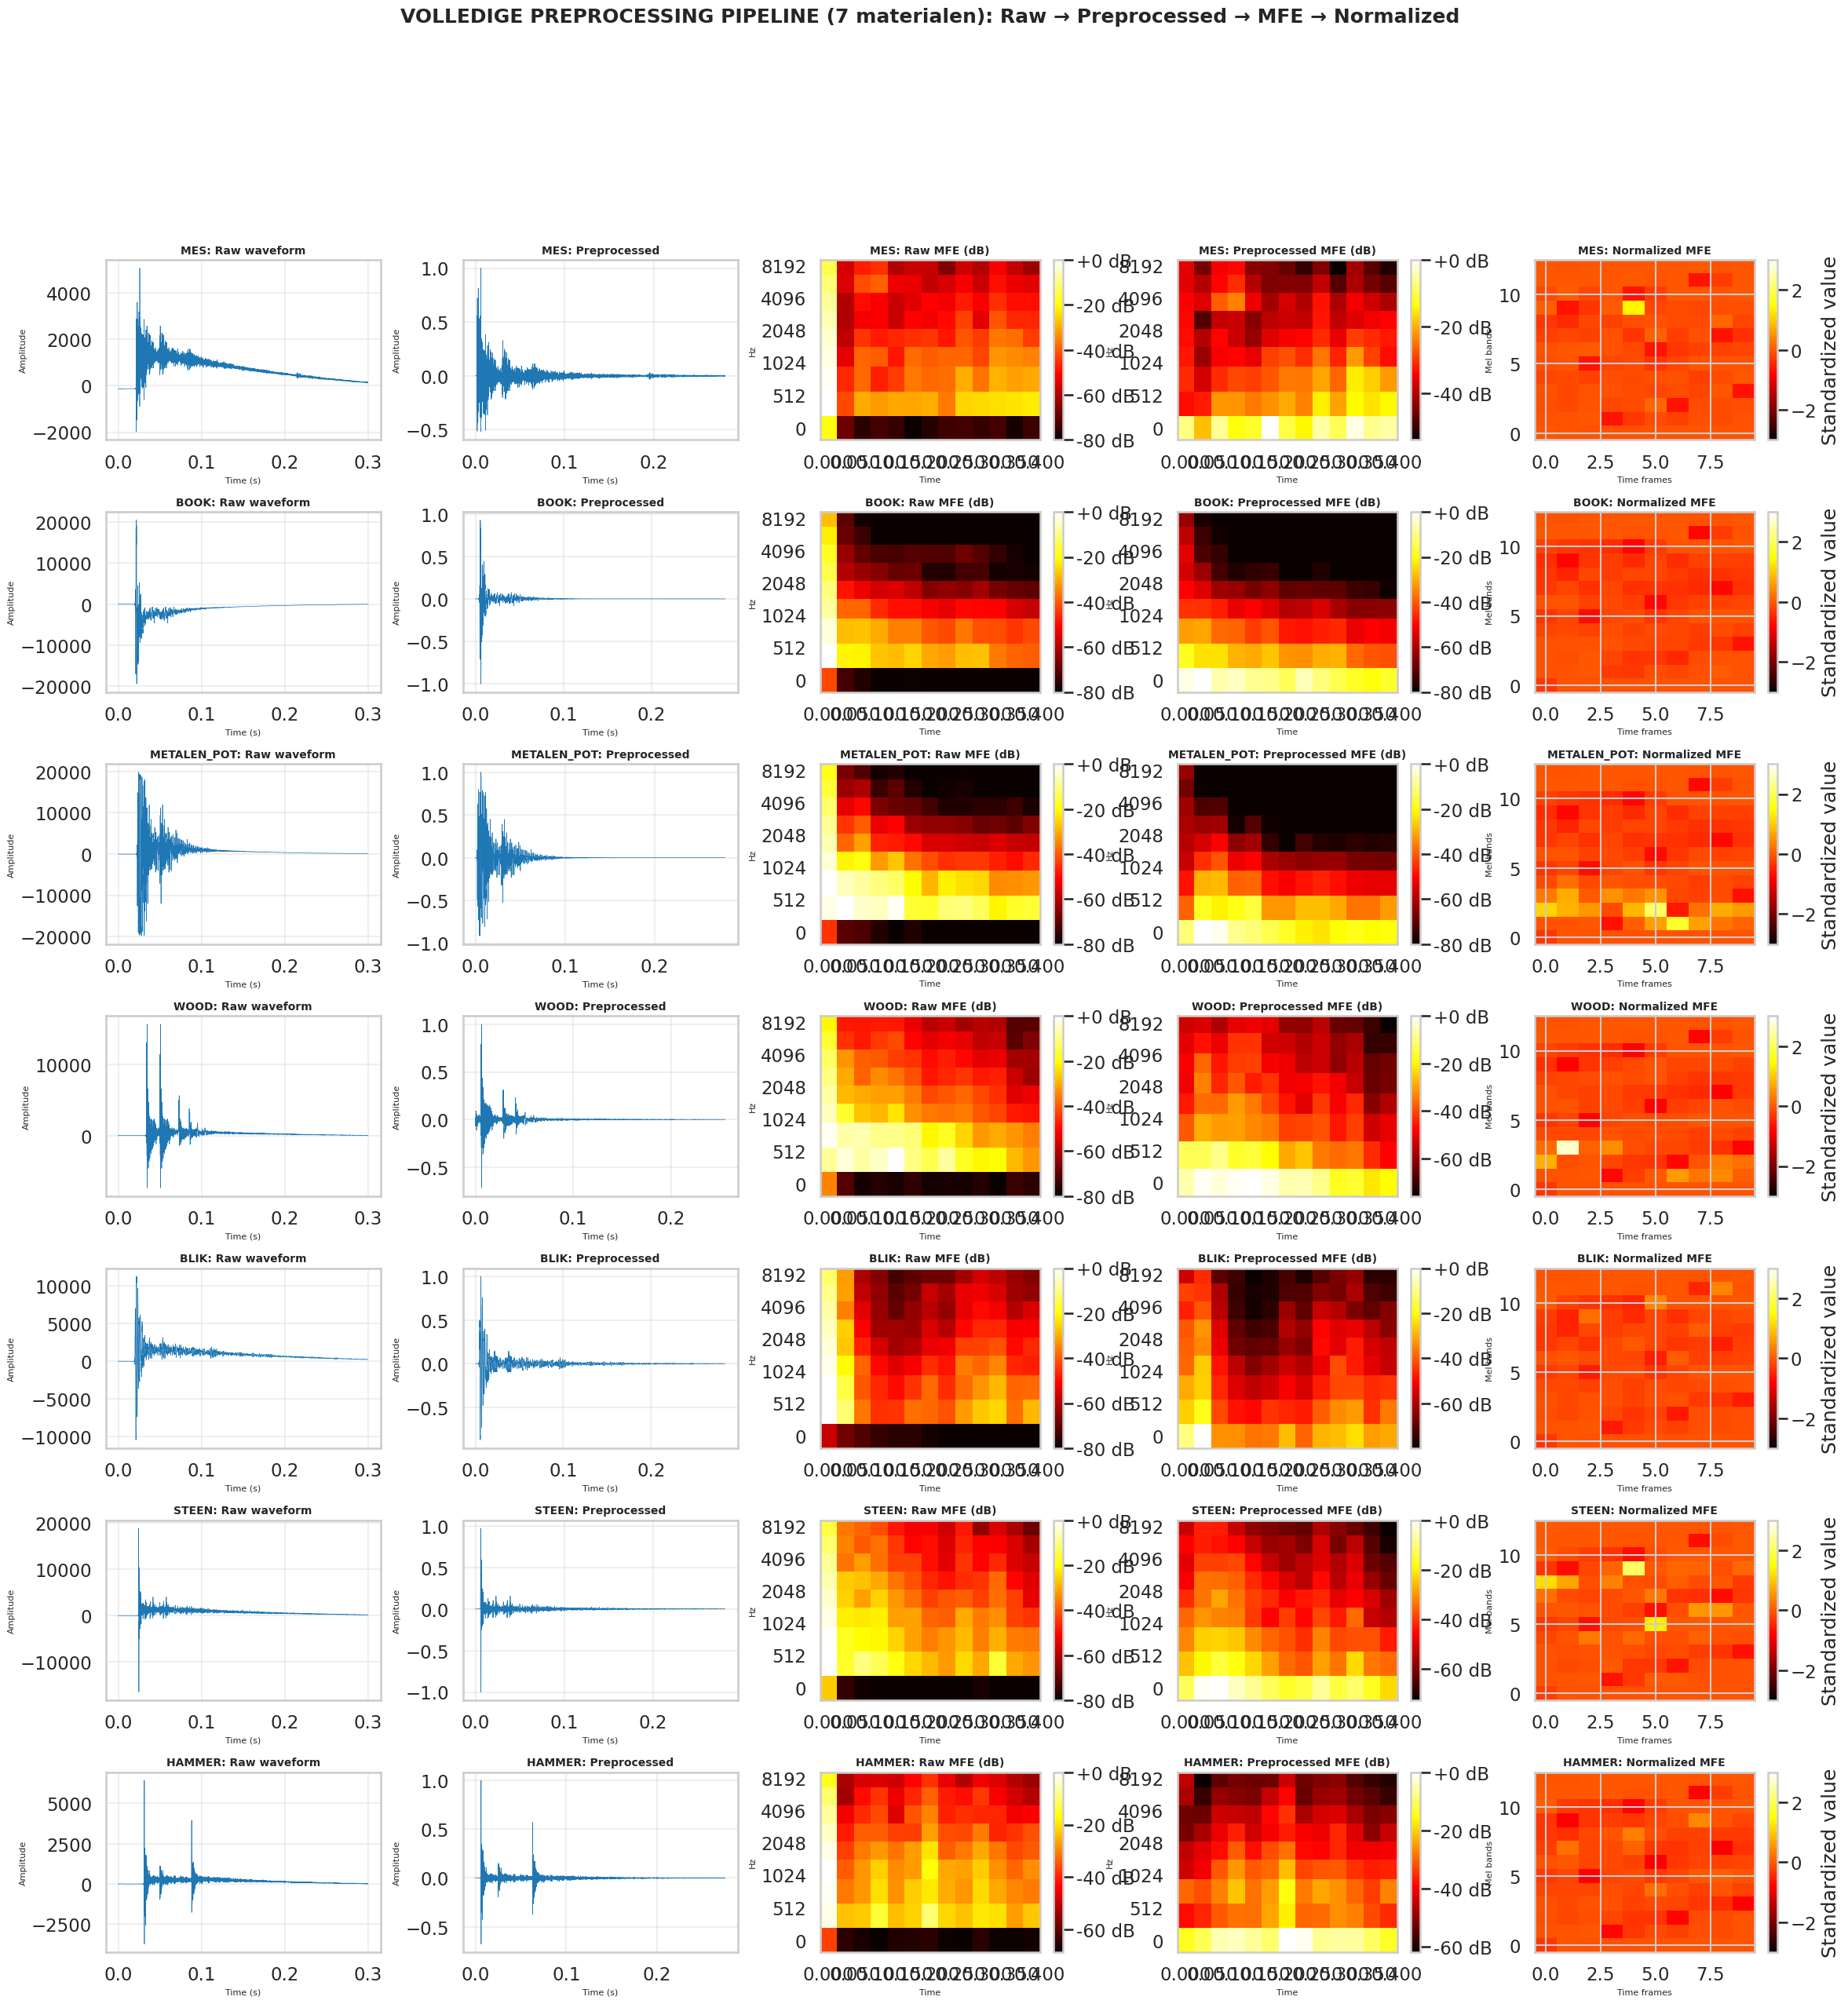

✓ Visualisatie voltooid voor alle materialen!

🎉 VOLLEDIGE PIPELINE SUCCESVOL UITGEVOERD!
📁 Data folder: /content/Data/
📁 Processed folder: /content/processed/
📁 Normalized folder: /content/normalized/
📊 Aantal materialen verwerkt: 7



In [111]:
print(f"\n{'='*60}")
print("STAP 3: VISUALISATIE VAN PREPROCESSING PIPELINE")
print(f"{'='*60}")

# Vind alle materialen in Data folder (DYNAMISCH)
available_materials = [f.stem for f in DATA_DIR.glob("*.csv")]
print(f"\nBeschikbare materialen voor visualisatie: {available_materials}")

if len(available_materials) == 0:
    print("⚠️  Geen materialen gevonden voor visualisatie!")
else:
    n_materials = len(available_materials)
    fig = plt.figure(figsize=(28, 4 * n_materials))
    gs = fig.add_gridspec(n_materials, 5, hspace=0.4, wspace=0.3)

    for idx, material in enumerate(available_materials):
        print(f"Visualiseren: {material}...")

        # Laad eerste hit
        df_raw = pd.read_csv(DATA_DIR / f"{material}.csv")
        signal = df_raw.iloc[0].values.astype(np.float32)

        # Preprocess signaal
        preprocessed = preprocess_signal(signal)
        mfe = extract_mfe_features(signal)
        mfe_preprocessed = extract_mfe_features(preprocessed)

        # Laad normalized MFE
        df_normalized = pd.read_csv(NORMALIZED_DIR / f"{material}_processed_normalized.csv")
        row_values = df_normalized.iloc[0].values.astype(np.float32)

        # Dynamisch reshape
        n_frames = len(row_values) // N_MELS
        remainder = len(row_values) % N_MELS
        if remainder != 0:
            # Voeg zero-padding toe
            row_values = np.pad(row_values, (0, N_MELS - remainder), mode='constant')
            n_frames += 1
        mfe_normalized = row_values.reshape(N_MELS, n_frames)

        # --- Plot 1: Raw waveform ---
        ax1 = fig.add_subplot(gs[idx, 0])
        time_raw = np.arange(len(signal)) / SR
        ax1.plot(time_raw, signal, linewidth=0.5, color='#1f77b4')
        ax1.set_title(f'{material.upper()}: Raw waveform', fontweight='bold', fontsize=10)
        ax1.set_xlabel('Time (s)', fontsize=8)
        ax1.set_ylabel('Amplitude', fontsize=8)
        ax1.grid(True, alpha=0.3)

        # --- Plot 2: Preprocessed waveform ---
        ax2 = fig.add_subplot(gs[idx, 1])
        time_prep = np.arange(len(preprocessed)) / SR
        ax2.plot(time_prep, preprocessed, linewidth=0.5, color='#1f77b4')
        ax2.set_title(f'{material.upper()}: Preprocessed', fontweight='bold', fontsize=10)
        ax2.set_xlabel('Time (s)', fontsize=8)
        ax2.set_ylabel('Amplitude', fontsize=8)
        ax2.grid(True, alpha=0.3)

        # --- Plot 3: Raw MFE (dB) ---
        ax3 = fig.add_subplot(gs[idx, 2])
        img3 = librosa.display.specshow(librosa.power_to_db(mfe, ref=np.max),
                                        x_axis='time', y_axis='mel',
                                        sr=SR, hop_length=HOP_LENGTH,
                                        ax=ax3, cmap='hot')
        ax3.set_title(f'{material.upper()}: Raw MFE (dB)', fontweight='bold', fontsize=10)
        ax3.set_xlabel('Time', fontsize=8)
        ax3.set_ylabel('Hz', fontsize=8)
        plt.colorbar(img3, ax=ax3, format='%+2.0f dB')

        # --- Plot 4: Preprocessed MFE (dB) ---
        ax4 = fig.add_subplot(gs[idx, 3])
        img4 = librosa.display.specshow(librosa.power_to_db(mfe_preprocessed, ref=np.max),
                                        x_axis='time', y_axis='mel',
                                        sr=SR, hop_length=HOP_LENGTH,
                                        ax=ax4, cmap='hot')
        ax4.set_title(f'{material.upper()}: Preprocessed MFE (dB)', fontweight='bold', fontsize=10)
        ax4.set_xlabel('Time', fontsize=8)
        ax4.set_ylabel('Hz', fontsize=8)
        plt.colorbar(img4, ax=ax4, format='%+2.0f dB')

        # --- Plot 5: Normalized MFE (standardized) ---
        ax5 = fig.add_subplot(gs[idx, 4])
        img5 = ax5.imshow(mfe_normalized, aspect='auto', origin='lower', cmap='hot',
                          vmin=-3, vmax=3)
        ax5.set_title(f'{material.upper()}: Normalized MFE', fontweight='bold', fontsize=10)
        ax5.set_xlabel('Time frames', fontsize=8)
        ax5.set_ylabel('Mel bands', fontsize=8)
        plt.colorbar(img5, ax=ax5, label='Standardized value')

    fig.suptitle(f'VOLLEDIGE PREPROCESSING PIPELINE ({n_materials} materialen): Raw → Preprocessed → MFE → Normalized',
                 fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print("✓ Visualisatie voltooid voor alle materialen!")

print(f"\n{'='*60}")
print("🎉 VOLLEDIGE PIPELINE SUCCESVOL UITGEVOERD!")
print(f"{'='*60}")
print(f"📁 Data folder: {DATA_DIR}/")
print(f"📁 Processed folder: {PROCESSED_DIR}/")
print(f"📁 Normalized folder: {NORMALIZED_DIR}/")
print(f"📊 Aantal materialen verwerkt: {len(available_materials)}")
print(f"{'='*60}\n")


#MODEL

In [112]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib
import matplotlib.pyplot as plt
import umap


In [113]:
NORMALIZED_DIR = Path("normalized")
K = 5
EPOCHS = 25
BATCH_SIZE = 16


In [114]:
X_orig = []
y_orig = []

for file in NORMALIZED_DIR.glob("*_normalized.csv"):
    material_name = file.stem.replace("_normalized", "").replace("_processed", "")
    df = pd.read_csv(file)
    for idx in range(len(df)):
        original = df.iloc[idx].values.astype(np.float32)
        X_orig.append(original)
        y_orig.append(material_name)

X_orig = np.array(X_orig, dtype=np.float32)
y_orig = np.array(y_orig)
print(f"✅ Originele dataset geladen: {X_orig.shape}, {y_orig.shape}")


✅ Originele dataset geladen: (556, 130), (556,)


In [115]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_orig)
classes = le.classes_
num_classes = len(classes)
joblib.dump(le, "label_encoder.pkl")
print(f"Labels: {classes}")


Labels: ['Book' 'blik' 'hammer' 'mes' 'metalen_pot' 'steen' 'wood']


In [116]:
def check_overlap_strict(X_train, X_test):
    train_set = set(map(tuple, X_train))
    test_set = set(map(tuple, X_test))
    overlap = train_set & test_set
    print(f"⚠️ Aantal overlappende samples tussen train/test: {len(overlap)}")
    if len(overlap) == 0:
        print("✅ Geen directe overlap gevonden.")

In [117]:
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_orig, y_encoded), 1):
    print(f"\n=== FOLD {fold}/{K} ===")

    # Split data
    X_train, X_test = X_orig[train_idx], X_orig[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    # Check overlap
    check_overlap_strict(X_train, X_test)

    # Model definitie
    model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    # Eerste laag iets groter voor betere expressiviteit
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Tweede laag kleiner
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    # Trainen
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=2
    )

    fold_results.append(history.history['val_accuracy'][-1])



=== FOLD 1/5 ===
⚠️ Aantal overlappende samples tussen train/test: 0
✅ Geen directe overlap gevonden.


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │         8,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079 (43.28 KB)

 Trainable params: 10,887 (42.53 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
28/28 - 3s - 98ms/step - accuracy: 0.3018 - loss: 2.1012 - val_accuracy: 0.5089 - val_loss: 1.6687
Epoch 2/25
28/28 - 0s - 6ms/step - accuracy: 0.5068 - loss: 1.4438 - val_accuracy: 0.7411 - val_loss: 1.4213
Epoch 3/25
28/28 - 0s - 6ms/step - accuracy: 0.6802 - loss: 1.0720 - val_accuracy: 0.7857 - val_loss: 1.2387
Epoch 4/25
28/28 - 0s - 6ms/step - accuracy: 0.7207 - loss: 0.9313 - val_accuracy: 0.8482 - val_loss: 1.0904
Epoch 5/25
28/28 - 0s - 6ms/step - accuracy: 0.7275 - loss: 0.8453 - val_accuracy: 0.8393 - val_loss: 0.9618
Epoch 6/25
28/28 - 0s - 6ms/step - accuracy: 0.7477 - loss: 0.7907 - val_accuracy: 0.8482 - val_loss: 0.8744
Epoch 7/25
28/28 - 0s - 6ms/step - accuracy: 0.7815 - loss: 0.6702 - val_accuracy: 0.8571 - val_loss: 0.7872
Epoch 8/25
28/28 - 0s - 7ms/step - accuracy: 0.7793 - loss: 0.6637 - val_accuracy: 0.8750 - val_loss: 0.6979
Epoch 9/25
28/28 - 0s - 6ms/step - accuracy: 0.8108 - loss: 0.5951 - val_accuracy: 0.8750 - val_loss: 0.6393
Epoch 10/25
28/28 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │         8,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079 (43.28 KB)

 Trainable params: 10,887 (42.53 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
28/28 - 3s - 97ms/step - accuracy: 0.2427 - loss: 2.0603 - val_accuracy: 0.5045 - val_loss: 1.7263
Epoch 2/25
28/28 - 0s - 8ms/step - accuracy: 0.4472 - loss: 1.4569 - val_accuracy: 0.7027 - val_loss: 1.4374
Epoch 3/25
28/28 - 0s - 7ms/step - accuracy: 0.6427 - loss: 1.1171 - val_accuracy: 0.7207 - val_loss: 1.2316
Epoch 4/25
28/28 - 0s - 6ms/step - accuracy: 0.6764 - loss: 0.9976 - val_accuracy: 0.7748 - val_loss: 1.0682
Epoch 5/25
28/28 - 0s - 6ms/step - accuracy: 0.7416 - loss: 0.8359 - val_accuracy: 0.8378 - val_loss: 0.9333
Epoch 6/25
28/28 - 0s - 6ms/step - accuracy: 0.7753 - loss: 0.7362 - val_accuracy: 0.8739 - val_loss: 0.8066
Epoch 7/25
28/28 - 0s - 7ms/step - accuracy: 0.7730 - loss: 0.7452 - val_accuracy: 0.8649 - val_loss: 0.7036
Epoch 8/25
28/28 - 0s - 7ms/step - accuracy: 0.8180 - loss: 0.5955 - val_accuracy: 0.8919 - val_loss: 0.6243
Epoch 9/25
28/28 - 0s - 7ms/step - accuracy: 0.8000 - loss: 0.5598 - val_accuracy: 0.9009 - val_loss: 0.5650
Epoch 10/25
28/28 

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 64)             │         8,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079 (43.28 KB)

 Trainable params: 10,887 (42.53 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
28/28 - 2s - 88ms/step - accuracy: 0.2989 - loss: 1.9872 - val_accuracy: 0.4865 - val_loss: 1.9226
Epoch 2/25
28/28 - 0s - 6ms/step - accuracy: 0.5326 - loss: 1.3692 - val_accuracy: 0.6847 - val_loss: 1.6727
Epoch 3/25
28/28 - 0s - 6ms/step - accuracy: 0.6899 - loss: 0.9903 - val_accuracy: 0.7297 - val_loss: 1.4618
Epoch 4/25
28/28 - 0s - 7ms/step - accuracy: 0.7303 - loss: 0.8656 - val_accuracy: 0.8108 - val_loss: 1.2963
Epoch 5/25
28/28 - 0s - 8ms/step - accuracy: 0.7730 - loss: 0.6848 - val_accuracy: 0.8649 - val_loss: 1.1728
Epoch 6/25
28/28 - 0s - 10ms/step - accuracy: 0.8225 - loss: 0.6397 - val_accuracy: 0.8919 - val_loss: 1.0746
Epoch 7/25
28/28 - 0s - 9ms/step - accuracy: 0.8382 - loss: 0.5688 - val_accuracy: 0.9099 - val_loss: 0.9572
Epoch 8/25
28/28 - 0s - 11ms/step - accuracy: 0.8315 - loss: 0.5609 - val_accuracy: 0.9099 - val_loss: 0.9309
Epoch 9/25
28/28 - 0s - 10ms/step - accuracy: 0.8247 - loss: 0.5183 - val_accuracy: 0.9279 - val_loss: 0.9157
Epoch 10/25
28/

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 64)             │         8,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079 (43.28 KB)

 Trainable params: 10,887 (42.53 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
28/28 - 2s - 88ms/step - accuracy: 0.2607 - loss: 2.1700 - val_accuracy: 0.4775 - val_loss: 1.6792
Epoch 2/25
28/28 - 0s - 7ms/step - accuracy: 0.4584 - loss: 1.5403 - val_accuracy: 0.6306 - val_loss: 1.4042
Epoch 3/25
28/28 - 0s - 7ms/step - accuracy: 0.5888 - loss: 1.1895 - val_accuracy: 0.7297 - val_loss: 1.2099
Epoch 4/25
28/28 - 0s - 7ms/step - accuracy: 0.6876 - loss: 0.9629 - val_accuracy: 0.7748 - val_loss: 1.0698
Epoch 5/25
28/28 - 0s - 7ms/step - accuracy: 0.7146 - loss: 0.8804 - val_accuracy: 0.7838 - val_loss: 0.9399
Epoch 6/25
28/28 - 0s - 7ms/step - accuracy: 0.7393 - loss: 0.7997 - val_accuracy: 0.8288 - val_loss: 0.8456
Epoch 7/25
28/28 - 0s - 6ms/step - accuracy: 0.8157 - loss: 0.6557 - val_accuracy: 0.8468 - val_loss: 0.7530
Epoch 8/25
28/28 - 0s - 7ms/step - accuracy: 0.8225 - loss: 0.6400 - val_accuracy: 0.8829 - val_loss: 0.6844
Epoch 9/25
28/28 - 0s - 6ms/step - accuracy: 0.8090 - loss: 0.5831 - val_accuracy: 0.8649 - val_loss: 0.6327
Epoch 10/25
28/28 

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 64)             │         8,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079 (43.28 KB)

 Trainable params: 10,887 (42.53 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
28/28 - 3s - 116ms/step - accuracy: 0.2854 - loss: 2.0324 - val_accuracy: 0.5766 - val_loss: 1.6585
Epoch 2/25
28/28 - 0s - 8ms/step - accuracy: 0.5303 - loss: 1.3109 - val_accuracy: 0.7297 - val_loss: 1.3969
Epoch 3/25
28/28 - 0s - 6ms/step - accuracy: 0.6382 - loss: 1.0671 - val_accuracy: 0.7838 - val_loss: 1.1882
Epoch 4/25
28/28 - 0s - 6ms/step - accuracy: 0.6899 - loss: 0.9313 - val_accuracy: 0.8288 - val_loss: 1.0218
Epoch 5/25
28/28 - 0s - 6ms/step - accuracy: 0.7753 - loss: 0.7844 - val_accuracy: 0.8739 - val_loss: 0.8922
Epoch 6/25
28/28 - 0s - 6ms/step - accuracy: 0.8090 - loss: 0.6458 - val_accuracy: 0.8829 - val_loss: 0.7891
Epoch 7/25
28/28 - 0s - 7ms/step - accuracy: 0.8022 - loss: 0.6325 - val_accuracy: 0.8468 - val_loss: 0.6958
Epoch 8/25
28/28 - 0s - 6ms/step - accuracy: 0.8292 - loss: 0.5464 - val_accuracy: 0.9009 - val_loss: 0.6199
Epoch 9/25
28/28 - 0s - 6ms/step - accuracy: 0.8112 - loss: 0.5518 - val_accuracy: 0.8739 - val_loss: 0.5692
Epoch 10/25
28/28

In [118]:
mean_acc = np.mean(fold_results)
std_acc = np.std(fold_results)
print(f"\n=== K-FOLD CROSS-VALIDATION RESULT ===")
print(f"Gemiddelde Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")



=== K-FOLD CROSS-VALIDATION RESULT ===
Gemiddelde Accuracy: 93.35% ± 1.74%


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


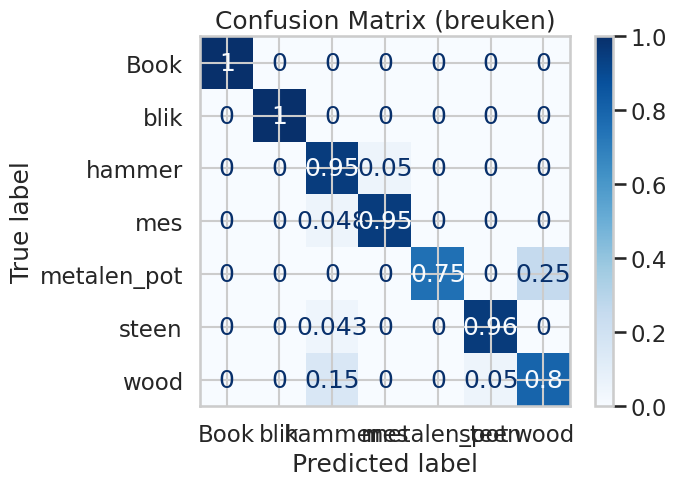


=== Accuracy per klasse ===
Book: 100.00% (4/4)
blik: 100.00% (19/19)
hammer: 95.00% (19/20)
mes: 95.24% (20/21)
metalen_pot: 75.00% (3/4)
steen: 95.65% (22/23)
wood: 80.00% (16/20)


In [119]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_fraction = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(cm_fraction, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (breuken)")
plt.show()

# Accuracy per klasse
print("\n=== Accuracy per klasse ===")
for cls, acc in zip(le.classes_, cm_fraction.diagonal()):
    print(f"{cls}: {acc*100:.2f}% ({int(cm.diagonal()[list(le.classes_).index(cls)])}/{cm.sum(axis=1)[list(le.classes_).index(cls)]})")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


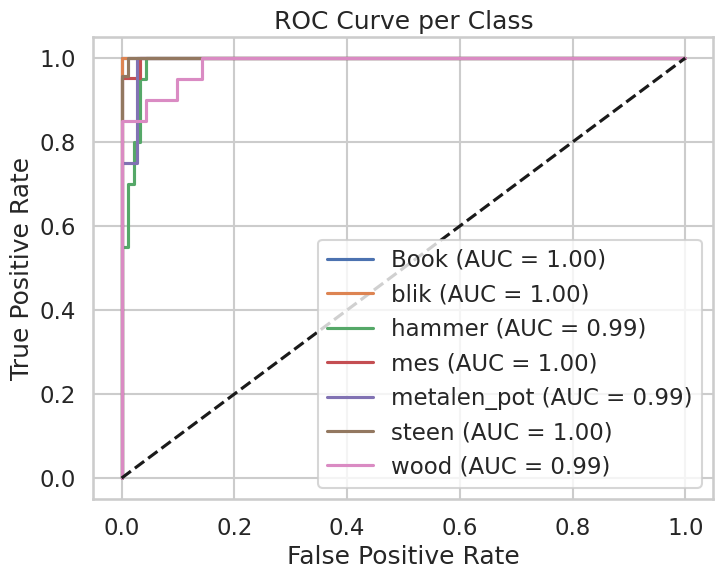

In [120]:
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
y_score = model.predict(X_test)

plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


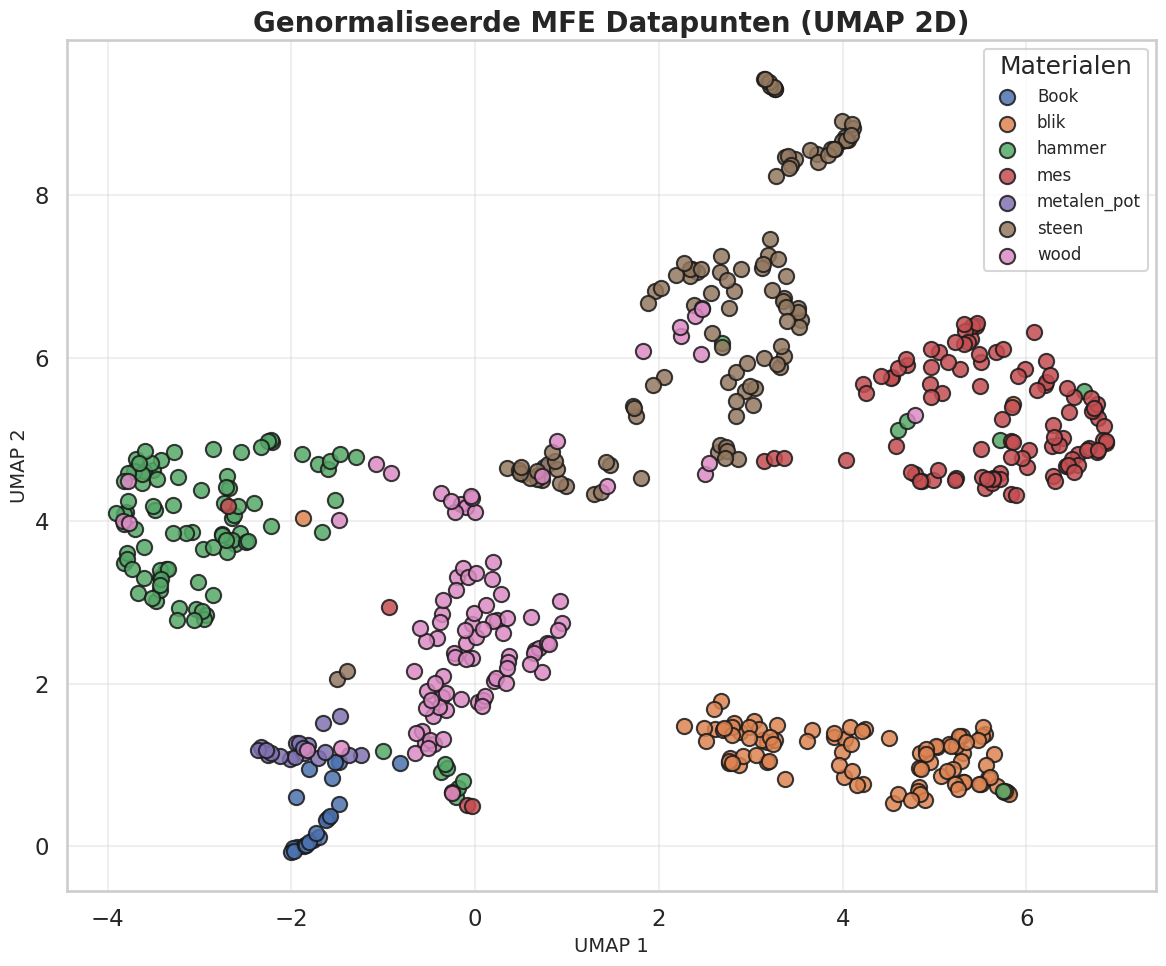

In [121]:
reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_orig)

plt.figure(figsize=(12, 10))
colors = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']

for i, cls in enumerate(classes):
    plt.scatter(
        X_umap[y_encoded == i, 0],
        X_umap[y_encoded == i, 1],
        alpha=0.85,
        s=120,
        label=cls,
        edgecolors='k'
    )

plt.title("Genormaliseerde MFE Datapunten (UMAP 2D)", fontsize=20, fontweight='bold')
plt.xlabel("UMAP 1", fontsize=14)
plt.ylabel("UMAP 2", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title="Materialen", fontsize=12)
plt.tight_layout()
plt.show()


In [122]:
import os
import tensorflow as tf

# Normaal TFLite model opslaan
tflite_model_file = "material_classifier.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

# Grootte in KB
size_kb = os.path.getsize(tflite_model_file) / 1024
print(f"✓ TFLite model opgeslagen: {tflite_model_file}, grootte: {size_kb:.2f} KB")

# Gequantiseerd TFLite model opslaan
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
quant_file = "material_classifier_quant.tflite"
with open(quant_file, "wb") as f:
    f.write(tflite_quant_model)

size_kb_quant = os.path.getsize(quant_file) / 1024
print(f"✓ Gequantiseerd TFLite model opgeslagen: {quant_file}, grootte: {size_kb_quant:.2f} KB")


Saved artifact at '/tmp/tmp3ofatlen'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 130), dtype=tf.float32, name='keras_tensor_152')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134284047507600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047510096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047514128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047514320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047512400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047508944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047515472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047509904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047506832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047512208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284047512016: T

In [123]:
with open("material_classifier.tflite", "rb") as f:
    data = f.read()

with open("model_data.h", "w") as f:
    f.write("const unsigned char material_classifier_tflite[] = {")
    f.write(','.join(str(b) for b in data))
    f.write("};\n")
    f.write(f"const unsigned int material_classifier_tflite_len = {len(data)};")


In [124]:
with open("material_classifier_quant.tflite", "rb") as f:
    data = f.read()

with open("modelQ_data.h", "w") as f:
    f.write("const unsigned char material_classifier_tflite_quant[] = {")
    f.write(','.join(str(b) for b in data))
    f.write("};\n")
    f.write(f"const unsigned int material_classifier_tflite_quant_len = {len(data)};")

In [125]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="material_classifier_quant.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print("Input shape:", input_details[0]['shape'])
print("Input dtype:", input_details[0]['dtype'])

Input shape: [  1 130]
Input dtype: <class 'numpy.float32'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [126]:
import numpy as np
import tensorflow as tf

# Laad het float32-model
interpreter = tf.lite.Interpreter(model_path="material_classifier.tflite")
interpreter.allocate_tensors()

# Haal invoer- en uitvoerdetails
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Maak testinvoer (zelfde als in Arduino)
# Het model verwacht 130 features (10 frames * 13 mel-bands)
# Pas de lengte van de array aan naar 130
test_features = np.array([-0.3179, -0.0568, -0.0741, -0.0767, -0.0839] + [0.0] * (130 - 5), dtype=np.float32)
test_features = np.reshape(test_features, (1, 130))  # Pas de shape aan aan het model (1, 130)

# Voer inference uit
interpreter.set_tensor(input_details[0]['index'], test_features)
interpreter.invoke()

# Haal de uitvoer
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Model output (float32):", output_data)

Model output (float32): [[0.02303119 0.538184   0.0892132  0.23947851 0.01359557 0.05419742
  0.04230005]]
